In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import expon, nbinom, norm, poisson, kstest
from scipy.optimize import minimize
from scipy.special import factorial
import warnings
warnings.filterwarnings("ignore")

import os

# thread issues
os.environ['OMP_NUM_THREADS'] = '6'  # Limit to 1 thread
os.environ['MKL_NUM_THREADS'] = '6'  # Limit to 1 thread for MKL (if used)
os.environ['NUMEXPR_NUM_THREADS'] = '6'  # Limit to 1 thread for NumExpr (if used)


# now the DCIS count data is found in an RDA file, which we apparently read using 'pyreadr'
import pyreadr


# to convert Ensemble to Refseq gene names
gene_convert = pyreadr.read_r('/path/to/ensemble_to_refseq_gene_name_table.rds')
gene_convert = gene_convert[None]
id_to_name = {gene_id: gene_name for gene_id, gene_name in zip(gene_convert["gene_id"], gene_convert["gene_name"])}


In [2]:
### Parameters ###

# whether or not we're doing outlier removal using trimmed means
trim_means_flag = True
trim_percent = 0 # 1% usually gets rid of most extreme outliers

# genes must be expressed in this % of patients (between 0-1)
express_percent_limit = 0.2 # set to 0 if you want patient stats (all genes with at least 1 read), set to 0.2 if we want AIC stats of genes with >20% expression

# library adjust (using fractional method)
adjust_for_lib = False

p_minimum = 0.01

# if we want ZINB to be run (it slows things down)
run_ZINB = True


In [3]:
# non-AIC related functions used in this program    

# computation of gene average, fraction of zeroes, and library size
def dataset_stats_generator(df, draw_zero_distribution = True):
    num_genes = df.shape[0]
    num_samples = df.shape[1]
    # Compute the metrics for each row
    row_sums = df.sum(axis = 0)
    fraction_zero_samples = (df == 0).sum(axis=0) / num_genes
    fraction_zero_genes = (df == 0).sum(axis=1) / num_samples
    row_means = df.mean(axis=1)

    if (draw_zero_distribution):
        plt.hist(fraction_zero_genes, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Fraction of Zeroes (Genes)')
        plt.ylabel('Frequency')
        plt.title("Fraction of Zeroes per Gene")
        plt.show()

        plt.hist(fraction_zero_samples, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Fraction of Zeroes (Samples)')
        plt.ylabel('Frequency')
        plt.title("Fraction of Zeroes per Sample")
        plt.show()

        plt.hist(row_means, bins=100, color='blue', alpha=0.7)
        plt.xlabel('Means of Gene Expression')
        plt.ylabel('Frequency')
        plt.title("Distribution of Means of Genes in Dataset")
        plt.show()
      
    # get the average of these 
    avg_library_size = np.round(np.sum(row_sums) / num_samples, decimals = 0)
    avg_zeroes = np.round(np.sum(fraction_zero_samples) / num_samples, decimals = 3)
    avg_mean_expression = np.round(np.mean(row_means), decimals = 3)
    
    # print("Avg Library Size", "Avg Fraction Zeroes", "Avg Mean Expression")
    return avg_library_size, avg_zeroes, avg_mean_expression

# Simulating some data for illustration
#data = np.random.negative_binomial(10, 0.5, 1000)

def fit_to_nb_plot(data, plotrange = 30):

    # Estimating parameters directly from data
    mean = np.mean(data)
    var = np.var(data)
    p = 1 - (mean / var)
    n = mean * (1 - p) / p

    # Plotting
    plt.hist(data, bins=range(plotrange), align='left', density=True, alpha=0.6, color='g')
    plt.plot(bins[:-1], nbinom.pmf(bins[:-1], n, p), 'ro-', lw=2)
    plt.title("Negative Binomial Fit")
    plt.show()

# adjust for library sizes
def library_adjust(data):
    if (adjust_for_lib):
        library_size = data.sum(axis=0)
        
        cleaned_matrix = np.round((data /library_size)*10000000)
        return cleaned_matrix
    else:
        return data

In [4]:
# functions to compute ZINB

def zinb_loglike(params, counts):
    mu, theta, pi = params
    p = 1 / (1 + mu/theta)
    n = mu * p / (1 - p)
    loglik_pois = nbinom.logpmf(counts, n, p)
    loglik_zero = np.log(pi + (1 - pi) * np.exp(nbinom.logpmf(0, n, p)))
    loglik = np.where(counts == 0, loglik_zero, np.log(1 - pi) + loglik_pois)
    return -np.sum(loglik)


def fit_zinb_and_calculate_aic(counts):
    
    initial_params = np.array([np.mean(counts), np.var(counts), 0.5])
    bounds = [(0, None), (0, None), (0, 1)]
    result = minimize(zinb_loglike, initial_params, args=(counts), bounds=bounds)
    mu, theta, pi = result.x
    return mu, theta, pi



In [5]:
# functions to compute ZIP
def zip_loglike(params, counts):
    mu, pi = params
    loglik_pois = poisson.logpmf(counts, mu)
    loglik_zero = np.log(pi + (1 - pi) * np.exp(poisson.logpmf(0, mu)))
    loglik = np.where(counts == 0, loglik_zero, np.log(1 - pi) + loglik_pois)
    return -np.sum(loglik)

def fit_zip_and_calculate_aic(counts):
    
    initial_params = np.array([np.mean(counts), 0.5])
    bounds = [(0, None), (0, 1)]
    result = minimize(zip_loglike, initial_params, args=(counts), bounds=bounds)
    mu, pi = result.x
    
    return mu, pi

In [6]:
# for ZINB
def cdf_zinb(x, pi, r, p):
    if x == 0:
        # Probability of zero not only from NB but also inflated by pi
        return pi + (1 - pi) * nbinom.cdf(0, r, p)
    else:
        # For x > 0, just the NB part adjusted by the inflation
        return pi + (1 - pi) * nbinom.cdf(x, r, p)


def neg_log_likelihood_zinb(params, data, pi_estimated):
    r, p = params
    if r <= 0 or p <= 0 or p >= 1:  # Avoid invalid parameters
        return np.inf

    # Handle zeros
    zero_data_likelihood = np.log(pi_estimated + (1 - pi_estimated) * nbinom.pmf(0, r, p))
    if np.isscalar(zero_data_likelihood):  # Ensure it's not a scalar
        zero_data_likelihood = np.array([zero_data_likelihood]) * np.sum(data == 0)
    else:
        zero_data_likelihood *= (data == 0)
    
    # Handle non-zeros
    non_zero_data = data[data > 0]
    if non_zero_data.size > 0:  # Ensure there are non-zero elements
        non_zero_data_likelihood = nbinom.logpmf(non_zero_data, r, p)
    else:
        non_zero_data_likelihood = np.array([])  # Use an empty array if no non-zero data

    # Combine likelihoods
    total_likelihood = np.sum(zero_data_likelihood) + np.sum(non_zero_data_likelihood)
    return -total_likelihood

# For ZIP
def cdf_zip(x, pi, lambda_):
    if x == 0:
        # Probability of zero inflated by pi
        # Since the Poisson probability of zero is exp(-lambda),
        # the total probability of zero includes both the inflation and the Poisson part.
        return pi + (1 - pi) * poisson.pmf(0, lambda_)
    else:
        # For x > 0, it's the Poisson CDF adjusted by the inflation
        # The adjustment involves subtracting the inflated zero probability to normalize the distribution
        return pi + (1 - pi) * poisson.cdf(x, lambda_)

def neg_log_likelihood_zip(params, counts, inflation_prob):
    lambda_, pi_ = params
    # Calculate the likelihood of the Poisson part (for non-zero counts)
    poisson_likelihood = (1 - inflation_prob) * (np.power(lambda_, counts) * np.exp(-lambda_)) / factorial(counts)
    poisson_likelihood[counts == 0] = 1  # Avoid division by zero for log(0)
    
    # Calculate the likelihood of the zero-inflated part
    zero_inflated_likelihood = pi_ + (1 - pi_) * np.exp(-lambda_)
    
    # Total likelihood
    likelihood = np.where(counts == 0, zero_inflated_likelihood, poisson_likelihood)
    
    # Return negative log likelihood
    return -np.sum(np.log(likelihood))

In [7]:
# estimating KS
def estimate_parameters_for_KS(data):
    
    # NB parameters: mean (mu) and variance (var) 
    mu = np.mean(data)
    var = np.var(data)
    
    # Exponential parameter (no need to alter)
    lambda_exp = 1 / mu
    
    # Estimation for NB parameters (r, p)
    X = sm.add_constant(np.ones(len(data)))
    res = sm.NegativeBinomial(data, X).fit(start_params=[1,1], disp=0)
    
    const = res.params[0]
    alpha = res.params[1]

    mu = np.exp(const)
    p_nb = 1/(1+np.exp(const)*alpha)
    r_nb = np.exp(const)*p_nb/(1-p_nb)

    # old, simpler way to estimate these parameters (they're actually quite close)
    #r_nb = mu**2 / (var - mu) if var > mu else mu
    #p_nb = mu / var if var > mu else 1

    # Gaussian parameters
    model_gaussian = sm.GLM(data, X, family=sm.families.Gaussian()).fit(disp=0)
    mu_gauss = np.mean(model_gaussian.predict(X))
    sigma_gauss = np.sqrt(model_gaussian.scale)

    # simple estimation
    #mu_gauss = mu
    #sigma_gauss = np.sqrt(var)

    # Poisson parameter
    model_poisson = sm.Poisson(data, X).fit(disp=0)
    lambda_pois = np.mean(model_poisson.predict(X))
    # lambda_pois = mu

    return (r_nb, p_nb, lambda_exp, mu_gauss, sigma_gauss, lambda_pois)

# row - a vector of expressions
def compare_KS_Value(row):
    
    row = np.round(row) # it must be count data
    
    # trimmed mean to remove outliers
    n = len(row)    
    if (trim_means_flag):
        elements_to_trim = int(np.floor(trim_percent / 100.0 * n))  
        sorted_data = np.sort(row)
        
        if (elements_to_trim > 0):
            row = sorted_data[elements_to_trim:-elements_to_trim]
        else: 
            row = sorted_data
            
    if (sum(row) <= 0):
        return ["ZEROES"]

    # Estimate parameters for both distributions
    r_nb, p_nb, lambda_exp, mu_gauss, sigma_gauss, lambda_pois = estimate_parameters_for_KS(row)
    
    # Generate CDF functions (using a lambda to encapsulate parameters)
    cdf_nb = lambda x: nbinom.cdf(x, r_nb, p_nb)
    cdf_exp = lambda x: expon.cdf(x, scale=1/lambda_exp)
    cdf_gauss = lambda x: norm.cdf(x, mu_gauss, sigma_gauss)
    cdf_pois = lambda x: poisson.cdf(x, lambda_pois)
    
    
    ks_stats = {}
    for dist_name, cdf_func in zip(["NB", "Exponential", "Gaussian", "Poisson"], [cdf_nb, cdf_exp, cdf_gauss, cdf_pois]):
        ks_stat, p_value = kstest(row, cdf_func)
        ks_stats[dist_name] = (ks_stat, p_value)
        #print(f"{dist_name} KS Statistic: {ks_stat}, p-value: {p_value}")
    
    # ZINB - only if there are zeroes
    if (run_ZINB == True):
        # (np.count_nonzero(row == 0) > 0) 

        # Data preparation and pi estimation
        initial_params = [1, 0.5]
        mu, zinb_theta, zinb_pi = fit_zinb_and_calculate_aic(row)
        mu, zip_pi = fit_zip_and_calculate_aic(row)

        # if pi is <0.1% of the dataset, lets ignore if it fits 
        if (np.isnan(zinb_pi) or np.isinf(zinb_pi) or zinb_pi < 0.00001):
            ks_stat_zip = 0
            p_value_zip = 0
            ks_stat_zinb = 0
            p_value_zinb = 0
        else:
            # MLE optimization
            # zinb
            result_zinb = minimize(neg_log_likelihood_zinb, initial_params, args=(row, zinb_pi),
                        method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, 1-1e-5)])

            r_estimated, p_estimated = result_zinb.x  
                    
            zinb_cdf_vectorized = np.vectorize(cdf_zinb, excluded=['pi', 'r', 'p'])
            ks_stat_zinb, p_value_zinb = kstest(row, zinb_cdf_vectorized, args=(zinb_pi, r_estimated, p_estimated))

            # zip
            result_zip = minimize(neg_log_likelihood_zip, initial_params, args=(row, zip_pi),
                        method='L-BFGS-B', bounds=[(1e-5, None), (1e-5, 1-1e-5)])

            r_estimated, p_estimated = result_zip.x  
                    
            zinb_cdf_vectorized = np.vectorize(cdf_zinb, excluded=['pi', 'r', 'p'])
            ks_stat_zip, p_value_zip = kstest(row, zinb_cdf_vectorized, args=(zinb_pi, r_estimated, p_estimated))
       
        
    else:
        ks_stat_zip = 0
        p_value_zip = 0
        ks_stat_zinb = 0
        p_value_zinb = 0
    
    
    ks_stats["ZINB"] = (ks_stat_zinb, p_value_zinb)    
    ks_stats["ZIP"] = (ks_stat_zip, p_value_zip)    
    

    # Report distributions with p-value > 0.05 (or p_minimum)
    acceptable_fits = [dist for dist, (ks_stat, p_value) in ks_stats.items() if p_value > p_minimum]
    if acceptable_fits:
        #print("Distributions fitting the data with p-value > 0.05:", " ".join(acceptable_fits))
        return acceptable_fits
    else:
        return ["None"]
  
    

In [8]:
# this is a dataset with 528 FFPE breast cancer samples, sequenced from a HiSeq
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE167977_third_party_ffpe/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns

tumours_counts_lib_adjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_lib_adjust == 0).mean(axis=1)
filtered_df = tumours_counts_lib_adjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_df = filtered_df.iloc[1:600]

ks_compared = filtered_df.apply(compare_KS_Value, axis=1)

best_fit_by_ks = ks_compared.value_counts()
print(best_fit_by_ks)

[NB]                       385
[None]                     114
[NB, Gaussian]              52
[NB, ZINB]                  19
[NB, Exponential]           17
[NB, Exponential, ZINB]      9
[Exponential]                3
dtype: int64


(23989, 528)


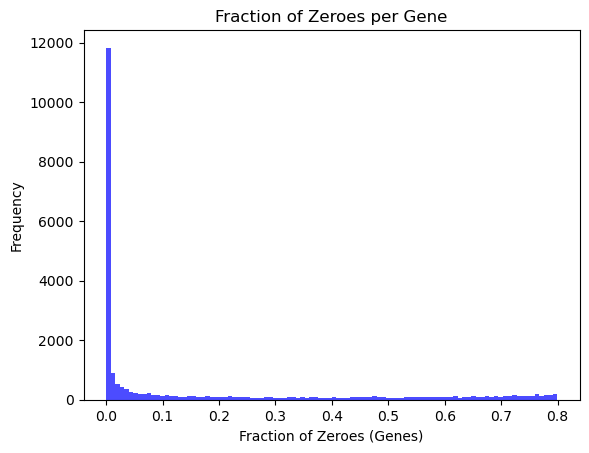

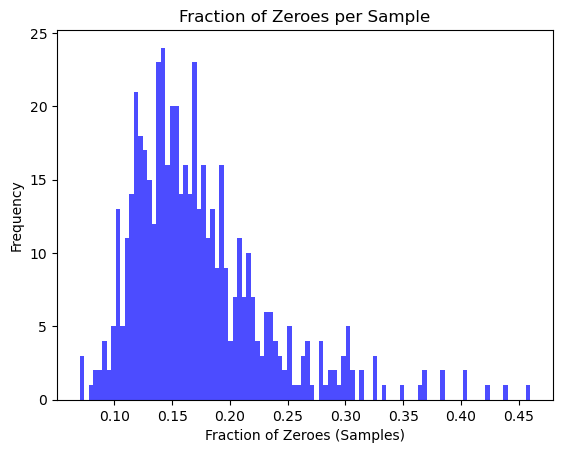

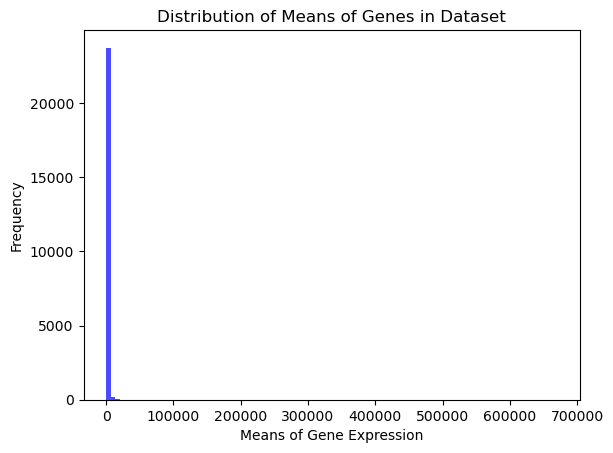

In [9]:
# this is a dataset with 528 FFPE breast cancer samples, sequenced from a HiSeq

data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE167977_third_party_ffpe/GSE167977_Raw_Counts.txt',
                  delimiter='\t')

# filter and compute dispersion
# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1) # column 1
tumours_counts = tumours_counts.drop(tumours_counts.columns[-5:], axis=1) # last 5 columns

# adjust for library size (fraction method)
# should come before the gene filter
tumours_counts_lib_adjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_lib_adjust == 0).mean(axis=1)
filtered_df = tumours_counts_lib_adjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients
print(filtered_df.shape)

dataset_stats = dataset_stats_generator(filtered_df, draw_zero_distribution=True)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])


In [10]:
# function to compute by row
print("GSE167977 - Highest KS P-Value across all genes")

ks_compared = filtered_df.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE167977 = ks_compared.value_counts()
print(best_fit_by_ks_GSE167977)

GSE167977 - Highest KS P-Value across all genes


[None]                     10637
[NB]                        9992
[NB, Gaussian]              1401
[NB, ZINB]                  1051
[NB, Exponential, ZINB]      363
[NB, Exponential]            272
[ZINB]                       148
[Exponential]                 99
[NB, Gaussian, ZINB]          13
[Gaussian]                     6
[Gaussian, ZINB]               4
[Exponential, ZINB]            3
dtype: int64


(19341, 97)


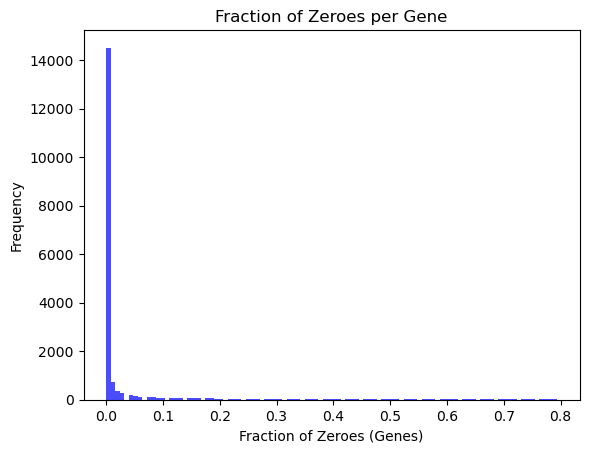

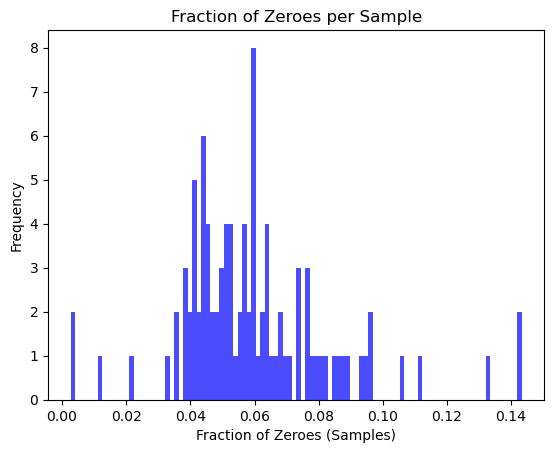

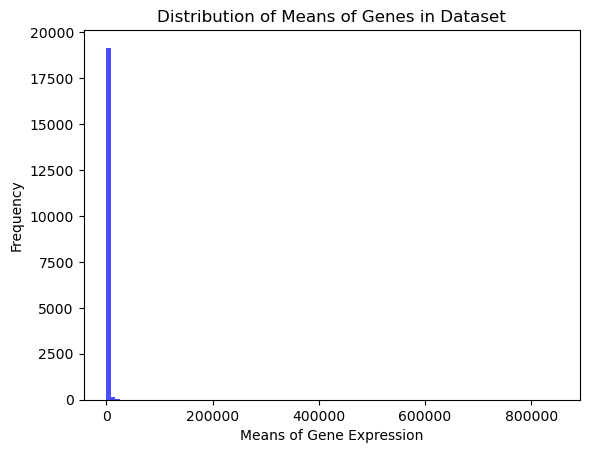

In [11]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE181466_third_party_ffpe/GSE181466_rsem_genes_matrix-97.txt',
                  delimiter='\t')

# patient information splitting is unnecessary, this appears to all be both FFPE and from tumours
# there is subtype and age information in the series matrix file, if we're interested

# dispersion of tumours - All Data
tumours_counts = pd.DataFrame(data)
# removing gene column at position 0
tumours_counts = tumours_counts.drop(tumours_counts.columns[0], axis=1)
# skip genes that are all zeroes, or just one spurrious read somewhere

# adjust for library size (fraction method)
tumours_counts_libadjust = library_adjust(tumours_counts)

fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients
print(filtered_df.shape)

dataset_stats = dataset_stats_generator(filtered_df)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])


In [12]:
print("GSE181466 - Highest KS P-Value across all genes")

ks_compared = filtered_df.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE181466 = ks_compared.value_counts()
print(best_fit_by_ks_GSE181466)

GSE181466 - Highest KS P-Value across all genes


[NB, Gaussian]                            9751
[None]                                    2873
[NB, Exponential]                         2088
[NB, Exponential, Gaussian]               1437
[NB]                                      1378
[NB, Exponential, ZINB]                    819
[NB, ZINB]                                 427
[NB, Exponential, Gaussian, ZINB]          289
[NB, Gaussian, ZINB]                       164
[Exponential]                               55
[ZINB]                                      16
[Poisson]                                   10
[Gaussian]                                   8
[Exponential, Poisson]                       6
[NB, Gaussian, Poisson, ZINB]                5
[Gaussian, Poisson]                          2
[Exponential, Gaussian, ZINB]                2
[Exponential, Gaussian]                      2
[Exponential, ZINB]                          2
[NB, Gaussian, Poisson]                      2
[Exponential, Gaussian, Poisson]             1
[Exponential,

Tumours (GSE146889)


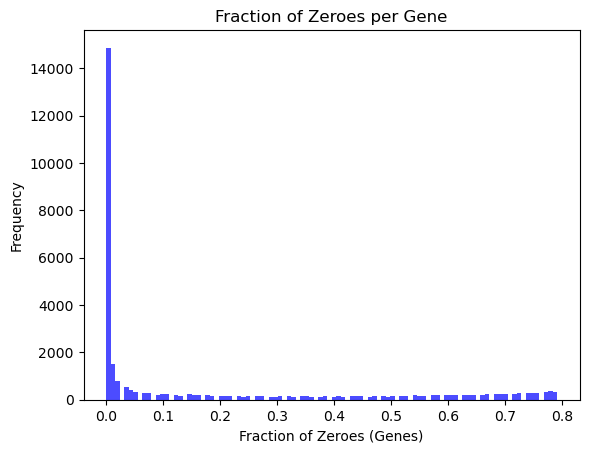

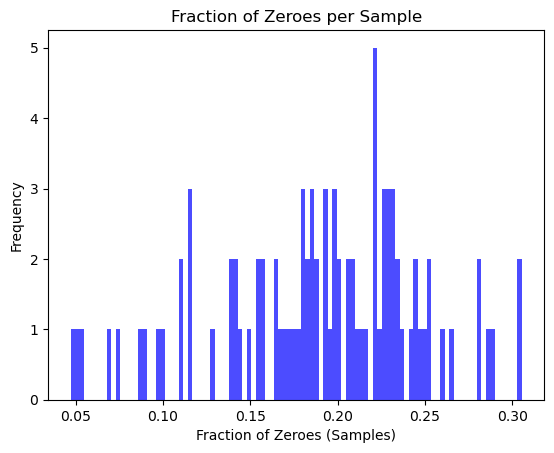

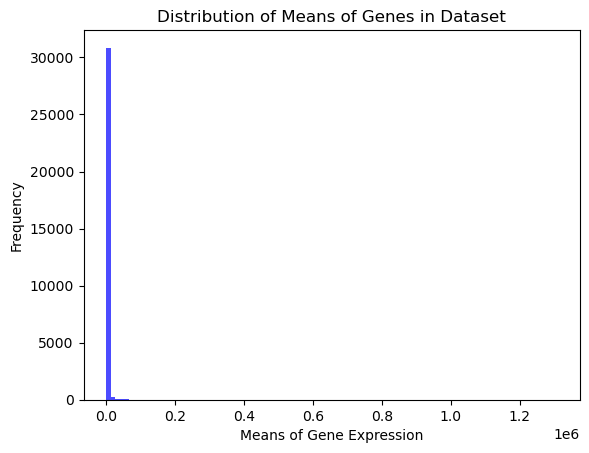

Normals


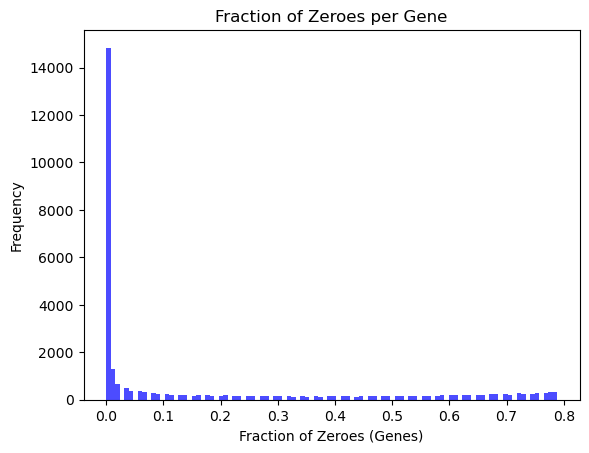

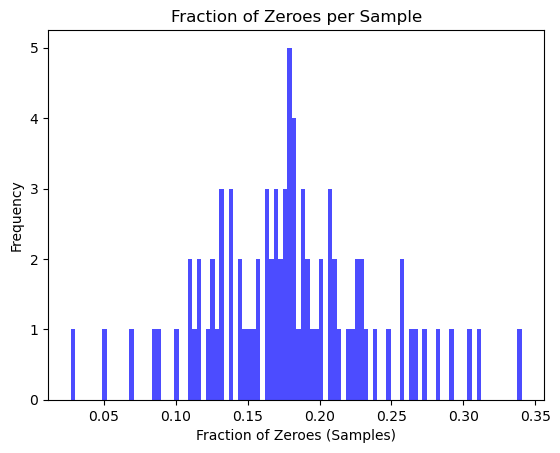

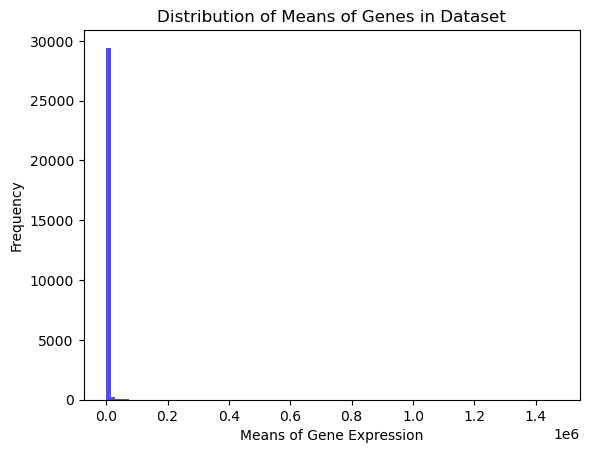

In [13]:
## here, we will repeat our plots but for a different data set
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE146889_third_party_ffpe/GSE146889_GeneCount.rds')
df = all_counts[None] # load all_counts into a pandas data frame

# we need to split the tumors and normals by name
count_TUMOR = df.filter(like='tumor')
count_NORMAL = df.filter(like='normal')

#filtered_tumour = count_TUMOR[count_TUMOR.sum(axis=1) > 1]
#filtered_normal = count_NORMAL[count_NORMAL.sum(axis=1) > 1]

# adjust for library size (fraction method)
count_TUMOR_libadjust = library_adjust(count_TUMOR)

fraction_of_zeroes = (count_TUMOR_libadjust == 0).mean(axis=1)
filtered_tumour = count_TUMOR_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("Tumours (GSE146889)")
dataset_stats = dataset_stats_generator(filtered_tumour)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])
#print(count_TUMOR_libadjust.shape)
#print(filtered_tumour.shape)


# adjust for library size (fraction method)
count_NORMAL_libadjust = library_adjust(count_NORMAL)

fraction_of_zeroes = (count_NORMAL_libadjust == 0).mean(axis=1)
filtered_normal = count_NORMAL_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print("Normals")
dataset_stats = dataset_stats_generator(filtered_normal)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])

In [14]:
print("GSE146889 Tumours - Highest KS P-Value across all genes")

ks_compared = filtered_tumour.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE146889_tumours = ks_compared.value_counts()
print(best_fit_by_ks_GSE146889_tumours)

GSE146889 Tumours - Highest KS P-Value across all genes


[None]                                        11350
[NB, Gaussian]                                10160
[NB, Exponential]                              2462
[NB, Exponential, ZINB]                        1775
[NB]                                           1588
[NB, Exponential, Gaussian]                    1408
[NB, Exponential, Gaussian, ZINB]               976
[NB, ZINB]                                      711
[NB, Gaussian, ZINB]                            616
[Exponential]                                   102
[Gaussian]                                       43
[ZINB]                                           19
[Poisson]                                         6
[Gaussian, ZINB]                                  6
[Exponential, Gaussian]                           6
[Exponential, Gaussian, ZINB]                     4
[Exponential, ZINB]                               3
[Exponential, Gaussian, Poisson]                  1
[NB, Exponential, Gaussian, Poisson, ZINB]        1
[Exponential

In [15]:
print("GSE146889 Normals - Highest KS P-Value across all genes")

ks_compared = filtered_normal.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE146889_normals = ks_compared.value_counts()
print(best_fit_by_ks_GSE146889_normals)

GSE146889 Normals - Highest KS P-Value across all genes


[None]                               10077
[NB, Gaussian]                        9862
[NB, Exponential]                     2020
[NB, Exponential, Gaussian]           1881
[NB]                                  1871
[NB, Exponential, ZINB]               1660
[NB, Exponential, Gaussian, ZINB]     1267
[NB, ZINB]                             609
[NB, Gaussian, ZINB]                   350
[Exponential]                           75
[Gaussian]                              68
[Poisson]                               14
[ZINB]                                  13
[Exponential, Gaussian, ZINB]            4
[Gaussian, ZINB]                         3
[Exponential, Poisson]                   2
[Gaussian, Poisson]                      1
[Exponential, Gaussian]                  1
[NB, Gaussian, Poisson]                  1
[Exponential, Gaussian, Poisson]         1
[Exponential, Poisson, ZINB]             1
dtype: int64


FFPE


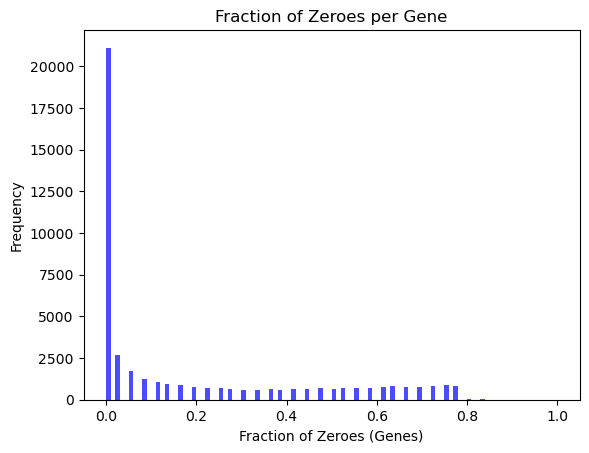

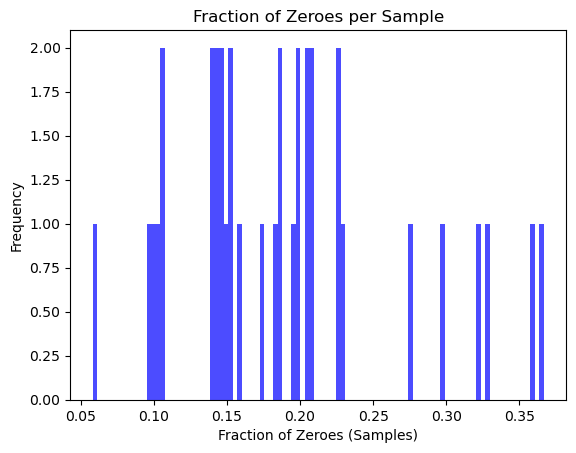

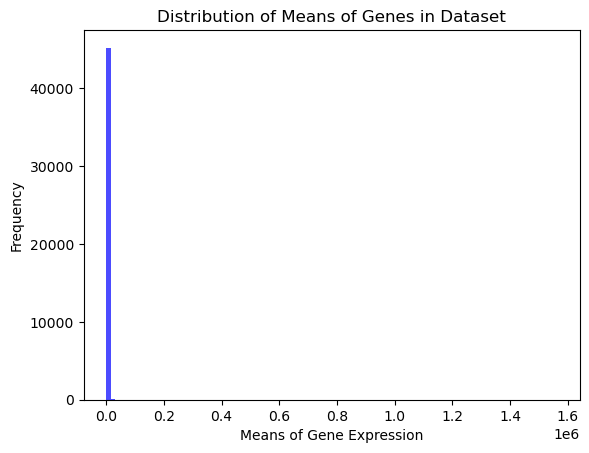

FFPE (45309, 36)
Fresh 93


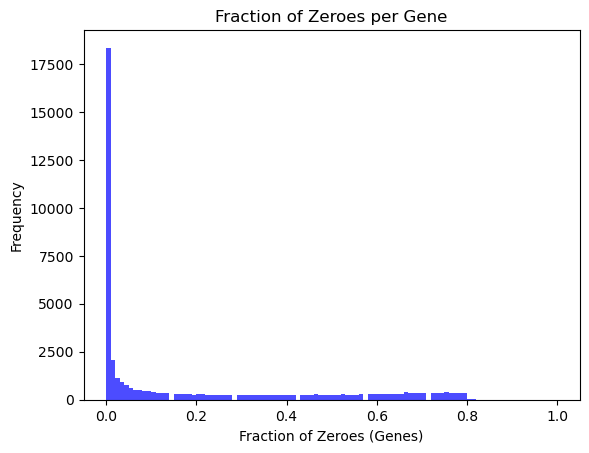

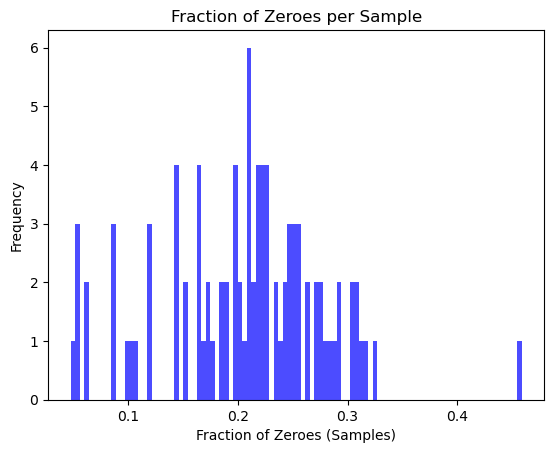

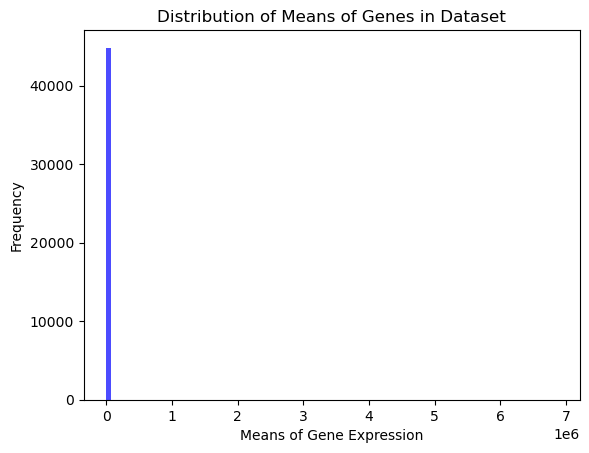

In [16]:
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE209998_third_party_ffpe/GSE209998_GeneCount.rds')
sample_information = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE209998_third_party_ffpe/GSE209998_Sample_Data.rds')

# now we want to isolate just the expression from a particular type of tissue
df_counts = all_counts[None] # load all_counts into a pandas data frame
df_sample = sample_information[None] # load all_counts into a pandas data frame

# here, we need to match if a sample is normal or tumour by !Sample_source_name_ch1 row

# so I need to: 1) match columns between sample_information and all_counts 
# are they in the same order
columns_df1 = df_counts.columns
columns_df2 = df_sample.columns

# Now we find what samples were tumours and what were normal
samples_row = df_sample.loc["!Sample_source_name_ch1"]

split_dfs = {}
for sample_type in samples_row.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and samples_row[col] == sample_type]
    split_dfs[sample_type] = df_counts[matching_columns]

sample_source = df_sample.loc["!Sample_source"]

split_source = {}
for sample_type in sample_source.unique():
    matching_columns = [col for col in df_counts.columns if col in df_sample.columns and sample_source[col] == sample_type]
    split_source[sample_type] = df_counts[matching_columns]


count_FRESH = split_source["Fresh frozen"]
count_FFPE = split_source["FFPE"]

#filtered_ffpe = count_FFPE[count_FFPE.sum(axis=1) > 1]
# adjust for library size (fraction method)
count_FFPE_libadjust = library_adjust(count_FFPE)
fraction_of_zeroes = (count_FFPE_libadjust == 0).mean(axis=1)
filtered_ffpe = np.round(count_FFPE_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients

print("FFPE")
dataset_stats = dataset_stats_generator(filtered_ffpe)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])


print("FFPE", filtered_ffpe.shape)

# adjust for library size (fraction method)
count_FRESH_libadjust = library_adjust(count_FRESH)
fraction_of_zeroes = (count_FRESH_libadjust == 0).mean(axis=1)
filtered_fresh = np.round(count_FRESH_libadjust[fraction_of_zeroes < (1 - express_percent_limit)]) # must be expressed to this percentage of patients
print("Fresh", filtered_fresh.shape[1])

dataset_stats = dataset_stats_generator(filtered_fresh)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])

In [17]:
print("GSE209998 FFPE - Highest KS P-Value across all genes")

ks_compared = filtered_ffpe.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE209998_ffpe = ks_compared.value_counts()
print(best_fit_by_ks_GSE209998_ffpe)

GSE209998 FFPE - Highest KS P-Value across all genes


[NB, Exponential, Gaussian]                   11736
[None]                                        11338
[NB, Gaussian]                                 8009
[NB, Exponential, Gaussian, ZINB]              3954
[NB, Exponential, Gaussian, Poisson, ZINB]     1979
[NB, Exponential]                              1782
[Gaussian]                                     1216
[NB, Exponential, ZINB]                         988
[Gaussian, Poisson]                             792
[NB, Exponential, Gaussian, Poisson]            781
[NB]                                            664
[NB, Gaussian, Poisson]                         533
[NB, ZINB]                                      518
[Poisson]                                       398
[NB, Gaussian, Poisson, ZINB]                   187
[NB, Gaussian, ZINB]                            164
[Exponential]                                    93
[Exponential, Gaussian]                          42
[Exponential, Gaussian, Poisson]                 36
[NB, Exponen

In [18]:
print("GSE209998 Fresh/Frozen Tumours - Highest KS P-Value across all genes")

ks_compared = filtered_fresh.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE209998_fresh = ks_compared.value_counts()
print(best_fit_by_ks_GSE209998_fresh)

GSE209998 Fresh/Frozen Tumours - Highest KS P-Value across all genes


[None]                                        19556
[NB, Gaussian]                                 8041
[NB, Exponential]                              5250
[NB]                                           3455
[NB, Exponential, Gaussian]                    2578
[NB, Exponential, ZINB]                        2482
[NB, ZINB]                                     1166
[NB, Exponential, Gaussian, ZINB]               978
[NB, Gaussian, ZINB]                            586
[Exponential]                                   386
[Poisson]                                       113
[Gaussian]                                       89
[ZINB]                                           45
[NB, Gaussian, Poisson, ZINB]                    27
[Exponential, Poisson]                           26
[NB, Gaussian, Poisson]                          20
[Exponential, ZINB]                              16
[Exponential, Gaussian]                          14
[Gaussian, Poisson, ZINB]                        12
[Exponential

(17291, 48)
(17096, 24)
Tumour


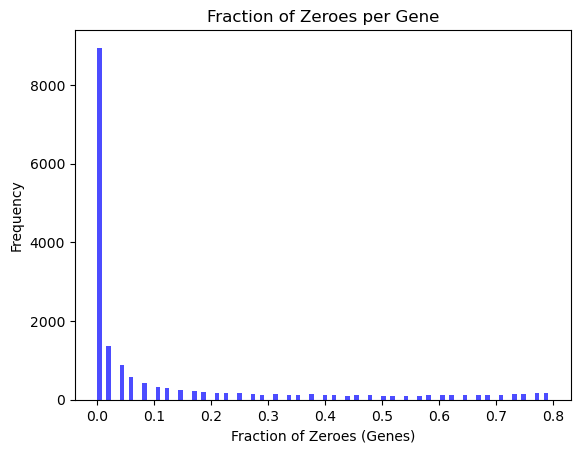

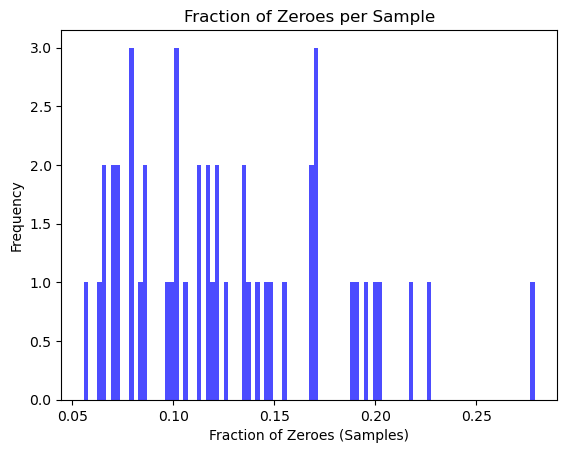

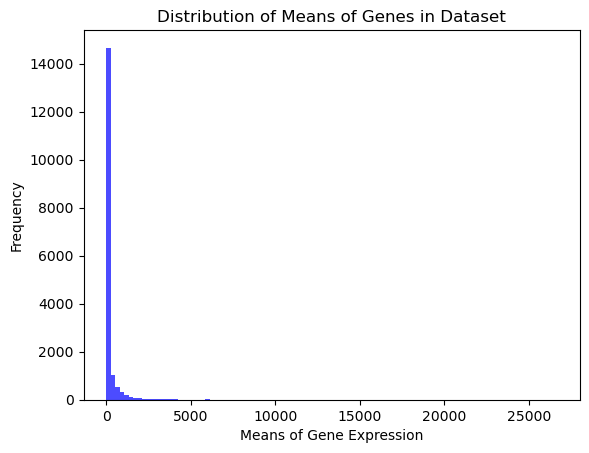

Normal


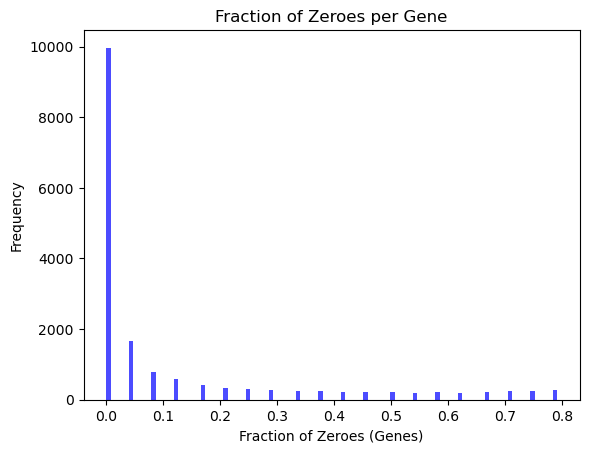

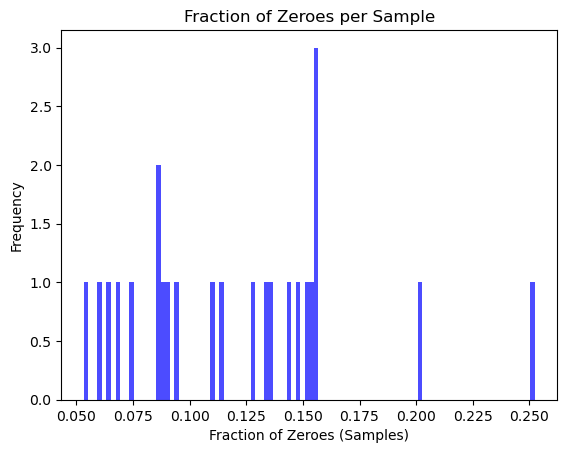

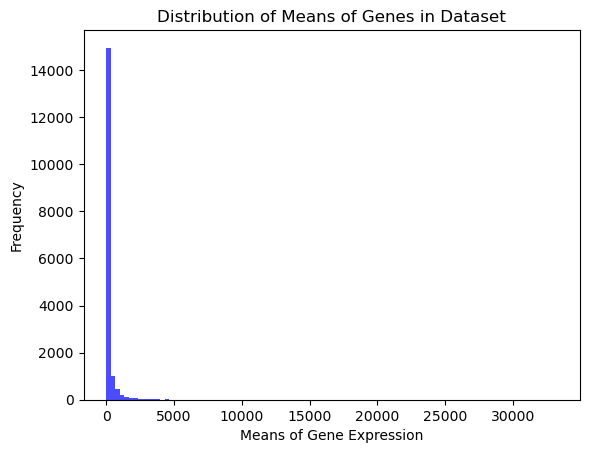

In [19]:
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE47462_third_party_ffpe/GSE47462_Raw_counts_Refseq_genes.txt',
                  delimiter='\t')
# Split the DataFrame into subsets based on column names indicating sample type
normal_data = data.filter(like='_normal')
EN_data = data.filter(like='_EN')
DCIS_data = data.filter(like='_DCIS')
IDC_data = data.filter(like='_IDC')

# since there isn't a ton of data, I also want to group tumors
tumours_data = data.loc[:, ~data.columns.str.contains('_normal')]
tumours_data = tumours_data.iloc[:, 1:]

#filtered_tumour = tumours_counts[tumours_counts.sum(axis=1) > 1]
#filtered_normal = normal_counts[normal_counts.sum(axis=1) > 1]

# adjust for library size (fraction method)
tumours_data_libadjust = library_adjust(tumours_data)
fraction_of_zeroes = (tumours_data_libadjust == 0).mean(axis=1)
filtered_tumour = tumours_data_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

normal_data_libadjust = library_adjust(normal_data)
fraction_of_zeroes = (normal_data_libadjust == 0).mean(axis=1)
filtered_normal = normal_data_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

print(filtered_tumour.shape)
print(filtered_normal.shape)

print("Tumour")
dataset_stats = dataset_stats_generator(filtered_tumour)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])

print("Normal")
dataset_stats = dataset_stats_generator(filtered_normal)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])

In [20]:
print("GSE47462 Tumours - Highest KS P-Value across all genes")

ks_compared = filtered_tumour.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE47462_tumours = ks_compared.value_counts()
print(best_fit_by_ks_GSE47462_tumours)

GSE47462 Tumours - Highest KS P-Value across all genes


[NB, Exponential, Gaussian]                   7765
[None]                                        2896
[NB, Exponential, Gaussian, ZINB]             2315
[NB, Gaussian]                                1276
[NB, Exponential]                              713
[NB, Exponential, Gaussian, Poisson, ZINB]     477
[NB, Exponential, ZINB]                        416
[Gaussian]                                     245
[NB, Exponential, Gaussian, Poisson]           242
[Gaussian, Poisson]                            216
[Poisson]                                      180
[NB]                                           130
[NB, ZINB]                                      90
[NB, Gaussian, Poisson]                         57
[Exponential]                                   48
[Exponential, Gaussian, Poisson]                45
[Exponential, Poisson]                          41
[NB, Gaussian, Poisson, ZINB]                   40
[NB, Gaussian, ZINB]                            24
[NB, Exponential, Poisson]     

In [21]:
print("GSE47462 Normal - Highest KS P-Value across all genes")

ks_compared = filtered_normal.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE47462_normals = ks_compared.value_counts()
print(best_fit_by_ks_GSE47462_normals)

GSE47462 Normal - Highest KS P-Value across all genes


[NB, Exponential, Gaussian]                   8554
[NB, Exponential, Gaussian, Poisson]          2055
[NB, Exponential, Gaussian, Poisson, ZINB]    1877
[None]                                        1497
[NB, Exponential, Gaussian, ZINB]             1194
[Gaussian]                                     601
[Gaussian, Poisson]                            517
[NB, Gaussian]                                 273
[NB, Gaussian, Poisson]                        211
[NB, Exponential]                               70
[Poisson]                                       50
[NB, Exponential, ZINB]                         45
[NB, ZINB]                                      29
[Exponential, Gaussian]                         25
[NB]                                            24
[Exponential, Gaussian, Poisson]                23
[Exponential, Poisson]                          10
[Exponential]                                   10
[NB, Gaussian, ZINB]                             9
[NB, Gaussian, Poisson, ZINB]  

(58233, 147)
(29223, 147)


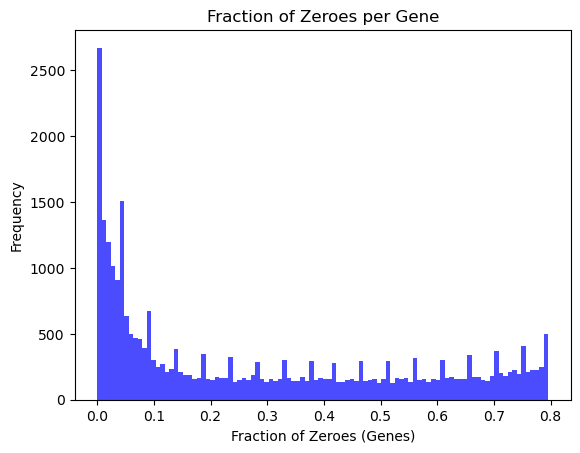

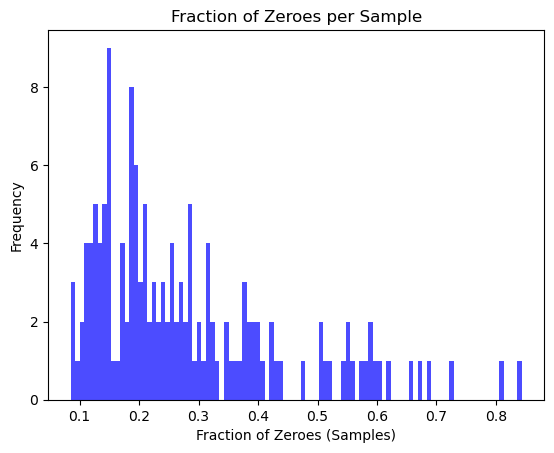

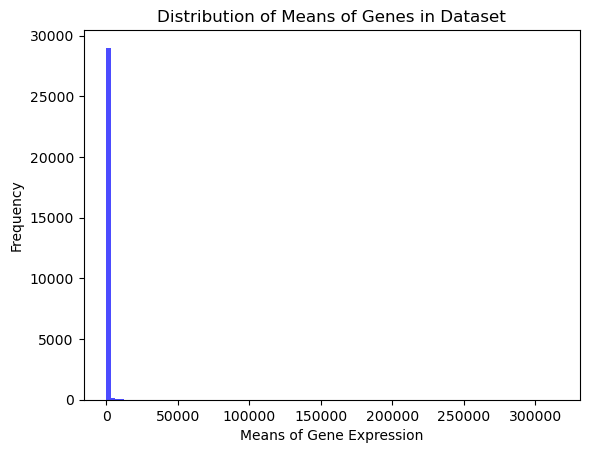

In [22]:
# Read the CSV file into a DataFrame
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE120795_third_party_ffpe/GSE120795_total_norms_raw_counts.tsv',
                  delimiter='\t')

# in the series matrix"disease: healthy", 
patient_info = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/GSE120795_third_party_ffpe/GSE120795_cell_info.txt',
                  delimiter='\t')

# this filter is present because those filtered out were not FFPE (blood and bone marrow)
mask = patient_info.iloc[0] == "healthy"

filtered_data = patient_info.loc[:, mask]
patient_names = filtered_data.columns
column_names_with_extension = [name + ".fastq.gz" for name in patient_names]
column_names_with_extension = column_names_with_extension[1:]

# Assuming 'second_list' is the list where you want to filter based on column names
filtered_data = data[column_names_with_extension]
ffpe_counts = pd.DataFrame(filtered_data)
#filtered_data = ffpe_counts[ffpe_counts.sum(axis=1) > 1]
print(ffpe_counts.shape)

ffpe_counts_libadjust = library_adjust(ffpe_counts)
fraction_of_zeroes = (ffpe_counts_libadjust == 0).mean(axis=1)
filtered_data = ffpe_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients
print(filtered_data.shape)

dataset_stats = dataset_stats_generator(filtered_data)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])


In [23]:
print("GSE120795 Normal - Highest KS P-Value across all genes")

ks_compared = filtered_data.apply(compare_KS_Value, axis=1)
best_fit_by_ks_GSE120795_normals = ks_compared.value_counts()
print(best_fit_by_ks_GSE120795_normals)

GSE120795 Normal - Highest KS P-Value across all genes


[None]                               16223
[NB, Exponential, ZINB]               5644
[NB, Exponential]                     1863
[NB, Exponential, Gaussian, ZINB]     1630
[NB, ZINB]                            1427
[NB]                                  1346
[NB, Exponential, Gaussian]            668
[NB, Gaussian]                         100
[Exponential, Gaussian, ZINB]           76
[Gaussian, ZINB]                        67
[NB, Gaussian, ZINB]                    65
[ZINB]                                  38
[Exponential, ZINB]                     34
[Gaussian]                              28
[Exponential, Gaussian]                  8
[Exponential]                            6
dtype: int64


(28278, 210)


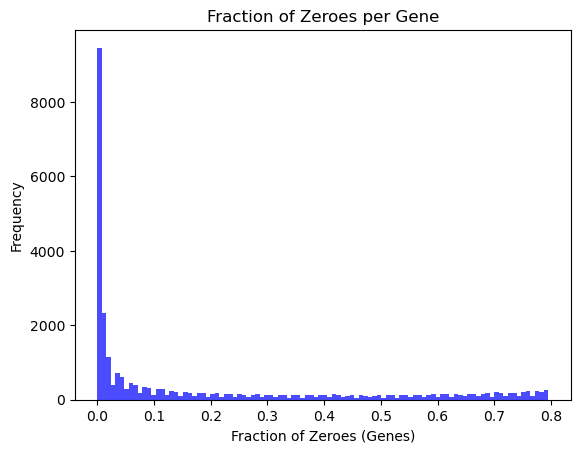

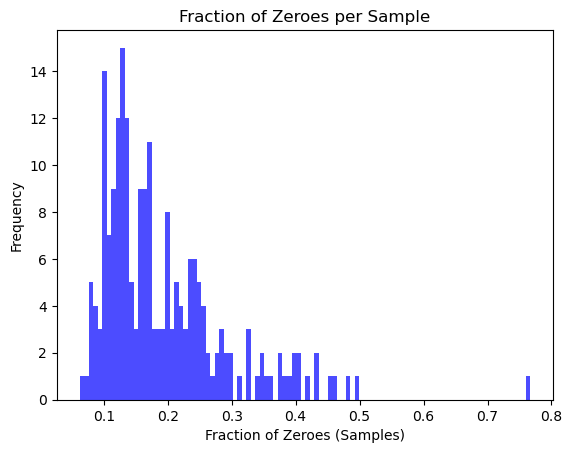

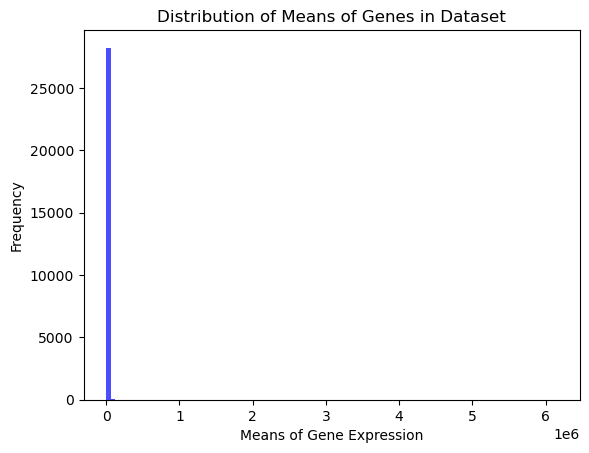

Average Library Size:  55553688.0
Fraction of Zeroes:  0.193
Average Mean Expression:  1964.555
(55553688.0, 0.193, 1964.555)


In [24]:
# the GDC Count-Me-In Data
data = pd.read_csv('/data/lab_vm/raw/preffect/7_datasets/third_party/CountMeIn_BConly_third_party_ffpe/MBC_CMI_Compiled_Counts.tsv',
                  delimiter=' ') # space delimited

tumours_counts = pd.DataFrame(data)
tumours_counts = tumours_counts.drop(tumours_counts.columns[:3], axis=1) # columns 1-3 should be ignored

# library adjust; remove genes expressed < express_percent_limit
tumours_counts_libadjust = library_adjust(tumours_counts)
fraction_of_zeroes = (tumours_counts_libadjust == 0).mean(axis=1)
filtered_df = tumours_counts_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients
print(filtered_df.shape)

dataset_stats = dataset_stats_generator(filtered_df)
print("Average Library Size: ", dataset_stats[0])
print("Fraction of Zeroes: ", dataset_stats[1])
print("Average Mean Expression: ", dataset_stats[2])
print(dataset_stats)

In [25]:
print("CMI BC Only - Highest KS P-Value across all genes")

ks_compared = filtered_df.apply(compare_KS_Value, axis=1)
best_fit_by_ks_CMI = ks_compared.value_counts()
print(best_fit_by_ks_CMI)

CMI BC Only - Highest KS P-Value across all genes


[None]                               11012
[NB]                                  8100
[NB, Exponential, ZINB]               2817
[NB, Gaussian]                        2306
[NB, ZINB]                            1980
[NB, Exponential]                     1326
[NB, Gaussian, ZINB]                   381
[ZINB]                                 161
[Exponential, ZINB]                     73
[Exponential]                           46
[NB, Exponential, Gaussian, ZINB]       30
[Gaussian, ZINB]                        29
[Gaussian]                               9
[NB, Exponential, Gaussian]              7
[Exponential, Gaussian, ZINB]            1
dtype: int64


DCIS
(23203, 220)


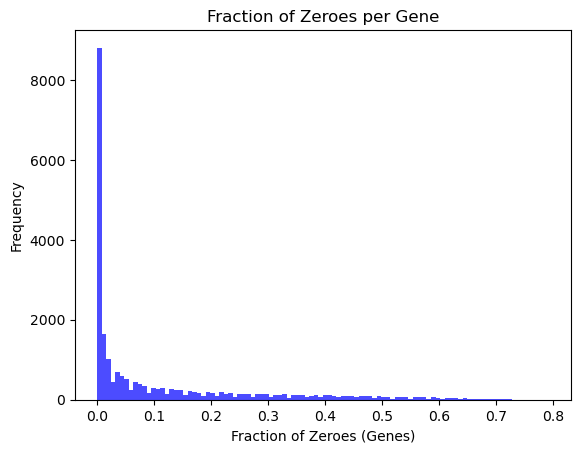

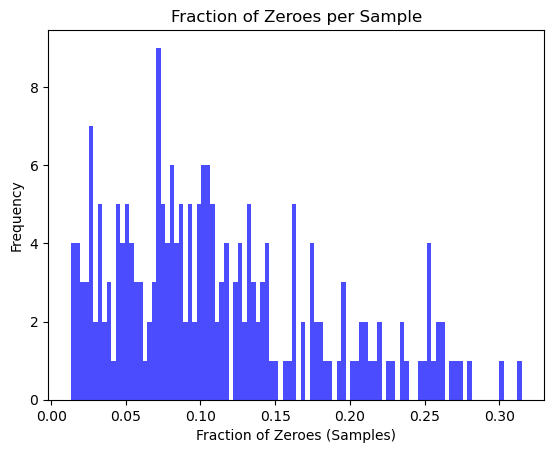

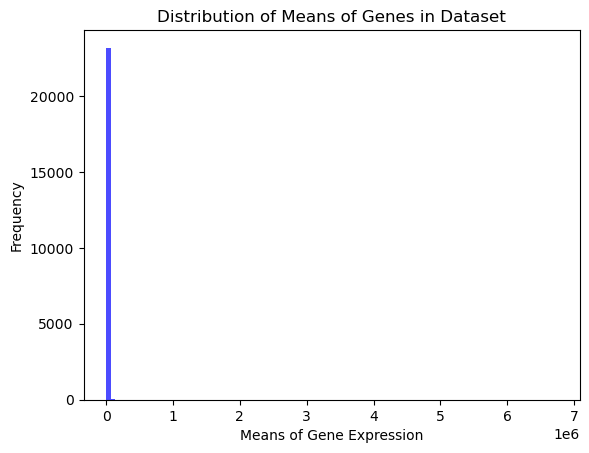

Stroma
(23048, 65)


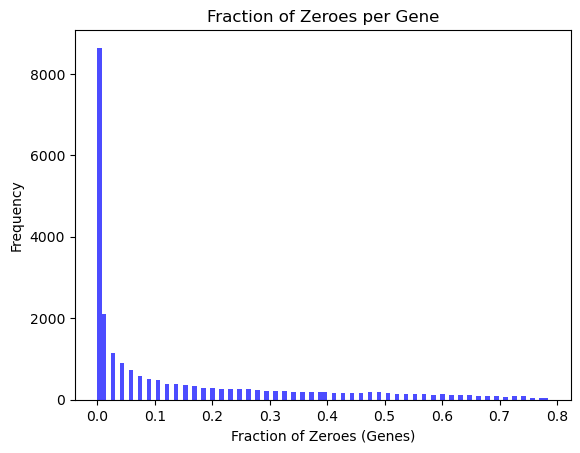

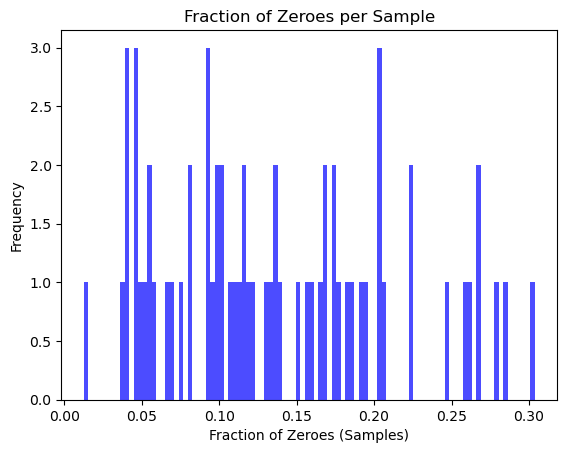

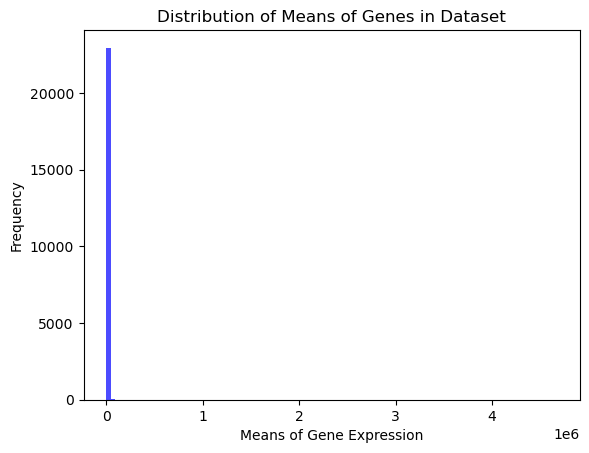

Normal
(23199, 101)


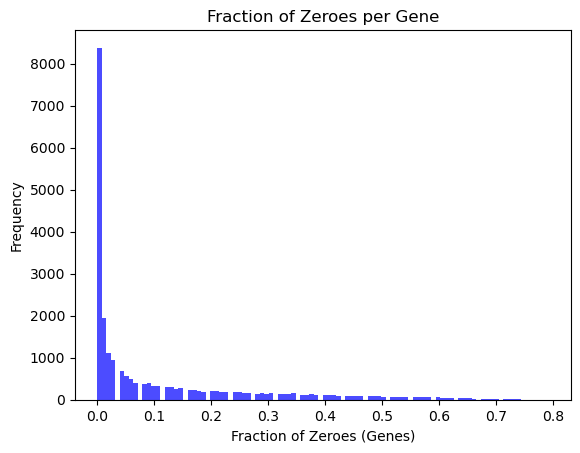

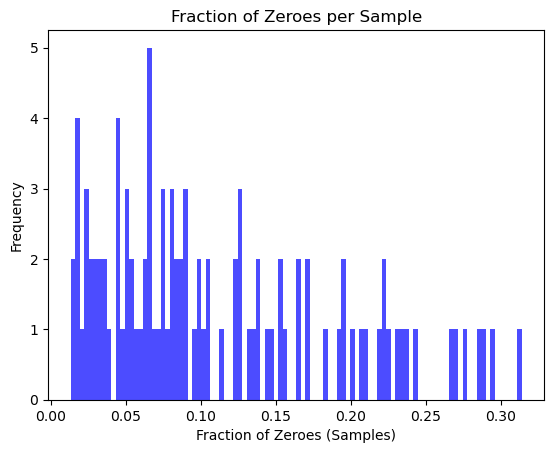

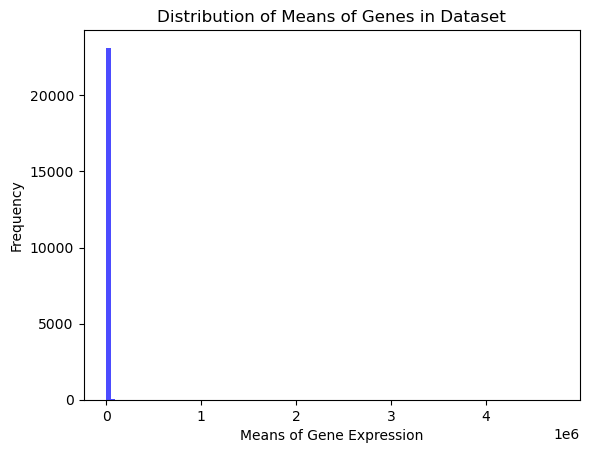

In [26]:
# Our dataset!
all_counts = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/expression_counts.Jan2023_1_2_and_2_2.rds')
vst_norm = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/expression_VST_Normalized.Jan2023_1_2_and_2_2.rds')

# this data is loading without issue
ship_data = pyreadr.read_r('/data/lab_vm/raw/preffect/7_datasets/our_dcis/ship1_2_full_tbl.Jan2023.With_Stroma_Assignment.rds')
# I wish that we could've simply used the RDA, but the counts-only RDS works and loads faster so what can you do
# in the future, could try the package 'rpy2' instead, it's an alternative that requires R but that's okay for us

# now we want to isolate just the expression from a particular type of tissue
df = all_counts[None] # load all_counts into a pandas data frame

# Eliminate any samples in the blacklist
ship_df = ship_data[None]
#print(ship_df['blacklist'].value_counts()) # they're all false

# since ship_data already has patients filtered out, lets filter out any patient who isn't on the list
# match by 'sample_name'
df_blacklist_filtered = df[ship_df['sample_name']]

# split the patients by tissue
count_DCIS = df_blacklist_filtered.filter(like='_D')
count_STROMA = df_blacklist_filtered.filter(like='_S')
count_NORMAL = df_blacklist_filtered.filter(like='_N')

# if we want consistency between the 3 sample types
vst_table = vst_norm[None] # we don't apply this anymore because it blocks any gene with >80% frac_zero
filtered_norm_count = count_NORMAL[count_NORMAL.index.isin(vst_table.index)]
filtered_tumour_count = count_DCIS[count_DCIS.index.isin(vst_table.index)]
filtered_stroma_count = count_STROMA[count_STROMA.index.isin(vst_table.index)]

filtered_norm_count_libadjust = library_adjust(filtered_norm_count)
fraction_of_zeroes = (filtered_norm_count_libadjust == 0).mean(axis=1)
filtered_norm_count = filtered_norm_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_tumour_count_libadjust = library_adjust(filtered_tumour_count)
fraction_of_zeroes = (filtered_tumour_count_libadjust == 0).mean(axis=1)
filtered_tumour_count = filtered_tumour_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients

filtered_stroma_count_libadjust = library_adjust(filtered_stroma_count)
fraction_of_zeroes = (filtered_stroma_count_libadjust == 0).mean(axis=1)
filtered_stroma_count = filtered_stroma_count_libadjust[fraction_of_zeroes < (1 - express_percent_limit)] # must be expressed to this percentage of patients



print("DCIS")
print(filtered_tumour_count.shape)
dataset_stats = dataset_stats_generator(filtered_tumour_count)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])

print("Stroma")
print(filtered_stroma_count.shape)
dataset_stats = dataset_stats_generator(filtered_stroma_count)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])

print("Normal")
print(filtered_norm_count.shape)
dataset_stats = dataset_stats_generator(filtered_norm_count)
#print("Average Library Size: ", dataset_stats[0])
#print("Fraction of Zeroes: ", dataset_stats[1])
#print("Average Mean Expression: ", dataset_stats[2])



In [27]:
print("Our Data DCIS - Highest KS P-Value across all genes")

ks_compared = filtered_tumour_count.apply(compare_KS_Value, axis=1)
best_fit_by_ks_DCIS = ks_compared.value_counts()
print(best_fit_by_ks_DCIS)

Our Data DCIS - Highest KS P-Value across all genes


[None]                               7584
[NB, Gaussian]                       4308
[NB]                                 4279
[NB, Exponential]                    2751
[NB, Exponential, ZINB]              1742
[NB, ZINB]                           1598
[Exponential]                         195
[ZINB]                                182
[Exponential, ZINB]                   181
[NB, Exponential, Gaussian]           167
[Gaussian]                            116
[NB, Gaussian, ZINB]                   61
[NB, Exponential, Gaussian, ZINB]      17
[Gaussian, ZINB]                       15
[Exponential, Gaussian]                 5
[Exponential, Gaussian, ZINB]           2
dtype: int64


In [28]:
print("Our Data Normals - Highest KS P-Value across all genes")

ks_compared = filtered_norm_count.apply(compare_KS_Value, axis=1)
best_fit_by_ks_DCISNorm = ks_compared.value_counts()
print(best_fit_by_ks_DCISNorm)

Our Data Normals - Highest KS P-Value across all genes


[None]                               5836
[NB, Gaussian]                       5749
[NB, Exponential, Gaussian]          2996
[NB, Exponential]                    2064
[NB, Exponential, ZINB]              2055
[NB]                                 1777
[NB, ZINB]                           1476
[NB, Exponential, Gaussian, ZINB]     853
[NB, Gaussian, ZINB]                  122
[Gaussian]                             59
[Exponential, Gaussian]                54
[Exponential, Gaussian, ZINB]          50
[ZINB]                                 46
[Exponential, ZINB]                    28
[Exponential]                          24
[Gaussian, ZINB]                       10
dtype: int64


In [29]:
print("Our Data Stroma - Highest KS P-Value across all genes")

ks_compared = filtered_stroma_count.apply(compare_KS_Value, axis=1)
best_fit_by_ks_DCISStrom = ks_compared.value_counts()
print(best_fit_by_ks_DCISStrom)

Our Data Stroma - Highest KS P-Value across all genes


[None]                               6287
[NB, Exponential, Gaussian]          4026
[NB, Gaussian]                       3922
[NB, Exponential]                    2202
[NB, Exponential, ZINB]              1795
[NB]                                 1745
[NB, ZINB]                           1513
[NB, Exponential, Gaussian, ZINB]    1302
[NB, Gaussian, ZINB]                  137
[Gaussian]                             43
[Exponential, Gaussian]                26
[Exponential]                          12
[Exponential, Gaussian, ZINB]          12
[ZINB]                                 12
[Exponential, ZINB]                     8
[Gaussian, ZINB]                        6
dtype: int64


In [30]:
# give each result a name
best_fit_by_ks_GSE167977.name = "GSE167977 (BC)"
best_fit_by_ks_GSE181466.name = "GSE181466 (TNBC)"
best_fit_by_ks_GSE146889_tumours.name = "GSE146889 (Colo./Endo.)"
best_fit_by_ks_GSE146889_normals.name = "GSE146889 (Normal)"
best_fit_by_ks_GSE209998_ffpe.name = "GSE209998 (BC|FFPE)"
best_fit_by_ks_GSE209998_fresh.name = "GSE209998 (BC|FRESH)"
best_fit_by_ks_GSE47462_tumours.name = "GSE47462 (BC)"
best_fit_by_ks_GSE47462_normals.name = "GSE47462 (Normal)"
best_fit_by_ks_GSE120795_normals.name = "GSE120795 (Normal)"
best_fit_by_ks_CMI.name = "TMBC Project"
best_fit_by_ks_DCIS.name = "DCIS (Tumour)"
best_fit_by_ks_DCISNorm.name = "DCIS (Normal)"
best_fit_by_ks_DCISStrom.name = "DCIS (Stroma)"

In [31]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

df = pd.DataFrame(columns=['Dataset', 'NB', 'Gaussian', 'Exponential', 'None', 'ZEROES'])

results = [best_fit_by_ks_GSE47462_tumours, best_fit_by_ks_GSE47462_normals,
            best_fit_by_ks_GSE120795_normals, best_fit_by_ks_GSE146889_tumours, best_fit_by_ks_GSE146889_normals,
            best_fit_by_ks_GSE167977, best_fit_by_ks_GSE181466, 
            best_fit_by_ks_GSE209998_ffpe, best_fit_by_ks_GSE209998_fresh, 
            best_fit_by_ks_CMI, best_fit_by_ks_DCIS, best_fit_by_ks_DCISNorm, best_fit_by_ks_DCISStrom]

for result_dict in results:
    category_counts = {}
    total_genes = 0
    for categories, count in result_dict.items():
        total_genes = total_genes + count
        # Skip if categories is None
        if categories is None:
            continue
        
        # Flatten the categories list if it's nested
        if any(isinstance(i, list) for i in categories):
            categories = flatten(categories)
        
        # Update counts for each category
        for category in categories:
            if category in category_counts:
                category_counts[category] += count
            else:
                category_counts[category] = count

    row = {'Dataset': result_dict.name, **category_counts}
    
    percentage_row = {key: (value / total_genes) for key, value in row.items() if key != 'Dataset'}
    
    df = df.append(percentage_row, ignore_index=True)
    

print(df)



    Dataset        NB  Gaussian  Exponential      None    ZEROES   Poisson  \
0       NaN  0.785438  0.736684     0.701463  0.167486       NaN  0.078075   
1       NaN  0.839846  0.897988     0.811710  0.087564       NaN  0.278545   
2       NaN  0.436061  0.090408     0.339767  0.555145       NaN       NaN   
3       NaN  0.630526  0.423221     0.215756  0.363328       NaN  0.000320   
4       NaN  0.655485  0.451261     0.232094  0.338370       NaN  0.000672   
5       NaN  0.545750  0.059361     0.030722  0.443412       NaN       NaN   
6       NaN  0.845923  0.603123     0.243110  0.148545       NaN  0.001499   
7       NaN  0.691916  0.649849     0.473791  0.250237  0.000132  0.105520   
8       NaN  0.547901  0.275821     0.261878  0.435594  0.000022  0.005145   
9       NaN  0.599300  0.097708     0.152062  0.389419       NaN       NaN   
10      NaN  0.643150  0.202172     0.218075  0.326854       NaN       NaN   
11      NaN  0.736756  0.426441     0.350188  0.251563       NaN

In [ ]:
# Creating a heatmap
# lets get rid of the "ZEROES" column
if 'ZEROES' in df.columns:
    df_zeroes_removed = df.drop('ZEROES', axis=1)

# change table to be based on percentages
df_filled = df_zeroes_removed.fillna(0)

# move the name from a column to row name
df_filled = df_filled.set_index('Dataset')

# convert counts to percentages
# with KS, a gene can contribute >=0 so it shouldn't be a sum of counts but of genes
# this now done earlier in the previous code box
#df_percent = df_filled.div(df_filled.sum(axis=1), axis=0) 

if (run_ZINB == True):
    new_order = ['NB', 'Gaussian', 'Exponential', 'Poisson', "ZINB", 'ZIP', 'None']
    missing_columns = [col for col in new_order if col not in df_filled.columns]
    # its for sure ZIP that's causing this issue
    if missing_columns:
        new_order = ['NB', 'Gaussian', 'Exponential', 'Poisson', "ZINB", 'None']

else: 
     new_order = ['NB', 'Gaussian', 'Exponential', 'Poisson', 'None']
df_percent = df_filled[new_order]

df_percent.index.name = None
print(df_percent.round(3))

# changing True/False to Yes/No for naming

if (adjust_for_lib == True):
    lib_adj = "Yes"
else:
    lib_adj = "No"

if (run_ZINB == True):
    run_ZINB = "Yes"
else:
    run_ZINB = "No"



#df_percent.to_csv('/path/to/6.5_Third_Party_Data.Best_Fit_Using_KS/Percent_Best_KS_Table.ZeroFract_' + 
#                     str(express_percent_limit) + ".Trim_" + str(trim_percent) + ".Lib_Adj_" + str(lib_adj) + ".p>" + str(p_minimum) + ".ZINB_" + str(run_ZINB) + ".csv" , index=True)


        NB  Gaussian  Exponential  Poisson   ZINB   None
0.0  0.785     0.737        0.701    0.078  0.197  0.167
0.0  0.840     0.898        0.812    0.279  0.185  0.088
0.0  0.436     0.090        0.340    0.000  0.307  0.555
0.0  0.631     0.423        0.216    0.000  0.132  0.363
0.0  0.655     0.451        0.232    0.001  0.131  0.338
0.0  0.546     0.059        0.031    0.000  0.066  0.443
0.0  0.846     0.603        0.243    0.001  0.089  0.149
0.0  0.692     0.650        0.474    0.106  0.173  0.250
0.0  0.548     0.276        0.262    0.005  0.119  0.436
0.0  0.599     0.098        0.152    0.000  0.194  0.389
0.0  0.643     0.202        0.218    0.000  0.164  0.327
0.0  0.737     0.426        0.350    0.000  0.200  0.252
0.0  0.722     0.411        0.407    0.000  0.208  0.273


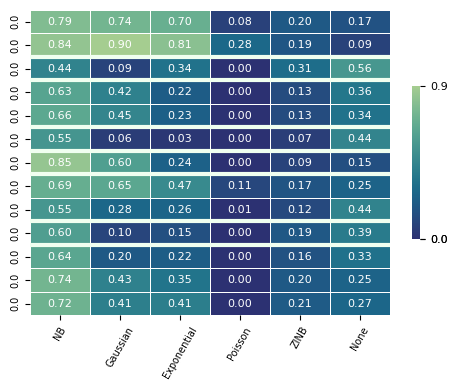

<Figure size 640x480 with 0 Axes>

In [ ]:
# lets use the table to create a heatmap
import seaborn as sns
import matplotlib.pyplot as plt


# Create the heatmap from percentage values above
plt.figure(figsize=(5, 4))
heatmap = sns.heatmap(df_percent, annot=True, fmt=".2f", cmap='crest_r', linewidths=.5,
                      annot_kws={"size": 8, "color": 'w'},  # Set annotation text color to black
                      cbar_kws={'shrink': 0.5, 'ticks': [0, 0.5, 1], 'format': '%.2f'})

# make X/Y labels smaller, and the figure a bit tighter
plt.yticks(fontsize=7)
plt.xticks(fontsize=7, rotation=60)
plt.tight_layout()

# draw a horizontal line between certain rows
gap_size = 3
plt.axhline(y=2, color='honeydew', linewidth=gap_size)
plt.axhline(y=3, color='honeydew', linewidth=gap_size)
plt.axhline(y=5, color='honeydew', linewidth=gap_size)
plt.axhline(y=6, color='honeydew', linewidth=gap_size)
plt.axhline(y=7, color='honeydew', linewidth=gap_size)
plt.axhline(y=9, color='honeydew', linewidth=gap_size)
plt.axhline(y=10, color='honeydew', linewidth=gap_size)

# to make the labels of the color bar show the top value
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  
cbar.set_ticks([cbar.vmin, 0, cbar.vmax])
cbar.set_ticklabels([f'{cbar.vmin:.1f}', '0.0', f'{cbar.vmax:.1f}'])

plot_title = "Distribution Fits Expr. by KS (p>"+ str(p_minimum) + ")- Gene Expr. >" + str(express_percent_limit) + ", MedianTrim " + str(trim_percent) + "%, Library Size Adjust:" + str(lib_adj) 
# plt.title(plot_title)

# save and display the plot
plt.savefig('/path/to/6.5_Third_Party_Data.Best_Fit_Using_KS/Percent_Best_KS_Table.ZeroFract_' + 
                     str(express_percent_limit) + ".Trim_" + str(trim_percent) + ".Lib_Adj_" + str(lib_adj) + ".p>" + str(p_minimum) + ".ZINB_" + str(run_ZINB) + ".png",
             dpi=300, bbox_inches='tight')  # dpi is dots per inch, for resolution

plt.savefig('/path/to/6.5_Third_Party_Data.Best_Fit_Using_KS/Percent_Best_KS_Table.ZeroFract_' + 
                     str(express_percent_limit) + ".Trim_" + str(trim_percent) + ".Lib_Adj_" + str(lib_adj) + ".p>" + str(p_minimum) + ".ZINB_" + str(run_ZINB) + ".pdf",
             dpi=300, bbox_inches='tight')  # dpi is dots per inch, for resolution

plt.show()

# Optional: Clear the figure after saving, so that future plt calls don't reuse the same figure
plt.clf()